In [1]:
import os

!rm -rf eagleview
os.makedirs('eagleview', exist_ok=True)
os.makedirs('eagleview/config', exist_ok=True)
os.makedirs('eagleview/data', exist_ok=True)
os.makedirs('eagleview/data/processed', exist_ok=True)
os.makedirs('eagleview/data/raw', exist_ok=True)
os.makedirs('eagleview/logs', exist_ok=True)
os.makedirs('eagleview/notebooks', exist_ok=True)
os.makedirs('eagleview/scripts', exist_ok=True)

os.makedirs('eagleview/checkpoints', exist_ok=True)
os.makedirs('eagleview/checkpoints/pretrained', exist_ok=True)
os.makedirs('eagleview/checkpoints/finetuned', exist_ok=True)

os.makedirs('eagleview/results', exist_ok=True)

In [2]:
parent_dir = './eagleview'
raw_data_path = os.path.join(parent_dir, 'data/raw')
processed_data_path = os.path.join(parent_dir, 'data/processed')
checkpoint_dir = os.path.join(parent_dir, 'checkpoints')

In [3]:
if not os.path.exists(raw_data_path + '/trainval.tar.gz'):
    os.system('wget https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz -P ' + raw_data_path )
    os.system('tar xf '+raw_data_path+'/trainval.tar.gz -C '+raw_data_path)

In [65]:
import numpy as np
import pandas as pd
import glob
import json
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import io
import os
from PIL import Image
import yaml
import seaborn as sns
sns.set()
%matplotlib inline

# <a>1. Collecting Data</a>

In [7]:
with open(raw_data_path+'/trainval/annotations/bbox-annotations.json') as json_data:
    data = json.load(json_data)

In [8]:
df_images = pd.DataFrame(data['images'])
df_images['file_path'] = raw_data_path + '/trainval/images/' + df_images['file_name']

In [9]:
df_images.head()

,file_name,width,height,id,license,file_path
0,image_000000001.jpg,1024,768,0,1,./eagleview/data/raw/trainval/images/image_000...
1,image_000000002.jpg,1024,576,1,1,./eagleview/data/raw/trainval/images/image_000...
2,image_000000003.jpg,1024,683,2,1,./eagleview/data/raw/trainval/images/image_000...
3,image_000000004.jpg,1024,675,3,1,./eagleview/data/raw/trainval/images/image_000...
4,image_000000005.jpg,1024,926,4,1,./eagleview/data/raw/trainval/images/image_000...


In [10]:
df_annotations = pd.DataFrame(data['annotations'])
df_annotations.head()

,category_id,image_id,segmentation,iscrowd,bbox,area,id,license
0,1,0,[],0,"[846, 145, 146, 477]",0.088554,0,2
1,1,0,[],0,"[848, 216, 175, 551]",0.122611,1,2
2,2,0,[],0,"[74, 159, 75, 81]",0.007725,2,2
3,2,0,[],0,"[153, 124, 658, 643]",0.537992,3,2
4,1,1,[],0,"[488, 281, 28, 71]",0.003370,4,2


In [11]:
df = pd.merge(df_images, df_annotations, left_on='id', right_on='image_id')
df.head()

,file_name,width,height,id_x,license_x,file_path,category_id,image_id,segmentation,iscrowd,bbox,area,id_y,license_y
0,image_000000001.jpg,1024,768,0,1,./eagleview/data/raw/trainval/images/image_000...,1,0,[],0,"[846, 145, 146, 477]",0.088554,0,2
1,image_000000001.jpg,1024,768,0,1,./eagleview/data/raw/trainval/images/image_000...,1,0,[],0,"[848, 216, 175, 551]",0.122611,1,2
2,image_000000001.jpg,1024,768,0,1,./eagleview/data/raw/trainval/images/image_000...,2,0,[],0,"[74, 159, 75, 81]",0.007725,2,2
3,image_000000001.jpg,1024,768,0,1,./eagleview/data/raw/trainval/images/image_000...,2,0,[],0,"[153, 124, 658, 643]",0.537992,3,2
4,image_000000002.jpg,1024,576,1,1,./eagleview/data/raw/trainval/images/image_000...,1,1,[],0,"[488, 281, 28, 71]",0.003370,4,2


In [12]:
df.describe()

,width,height,id_x,license_x,category_id,image_id,iscrowd,area,id_y,license_y
count,16772.000000,16772.000000,16772.000000,16772.0,16772.00000,16772.000000,16772.0,16772.000000,16772.000000,16772.0
mean,999.082220,742.922371,1090.303363,1.0,1.35607,1090.303363,0.0,0.065363,8385.500000,2.0
std,102.926163,125.908542,642.705912,0.0,0.47885,642.705912,0.0,0.157283,4841.803693,0.0
min,575.000000,282.000000,0.000000,1.0,1.00000,0.000000,0.0,0.000000,0.000000,2.0
25%,1024.000000,683.000000,523.000000,1.0,1.00000,523.000000,0.0,0.002963,4192.750000,2.0
50%,1024.000000,696.000000,1082.000000,1.0,1.00000,1082.000000,0.0,0.010517,8385.500000,2.0
75%,1024.000000,768.000000,1630.000000,1.0,2.00000,1630.000000,0.0,0.038902,12578.250000,2.0
max,4496.000000,3000.000000,2238.000000,1.0,2.00000,2238.000000,0.0,0.998048,16771.000000,2.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16772 entries, 0 to 16771
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   file_name     16772 non-null  object 
 1   width         16772 non-null  int64  
 2   height        16772 non-null  int64  
 3   id_x          16772 non-null  int64  
 4   license_x     16772 non-null  int64  
 5   file_path     16772 non-null  object 
 6   category_id   16772 non-null  int64  
 7   image_id      16772 non-null  int64  
 8   segmentation  16772 non-null  object 
 9   iscrowd       16772 non-null  int64  
 10  bbox          16772 non-null  object 
 11  area          16772 non-null  float64
 12  id_y          16772 non-null  int64  
 13  license_y     16772 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 1.9+ MB


# </a> 2. Data Assessment </a>

COCO bounding box format is [top left x position, top left y position, width, height].

In [70]:
def box_coordinates(bbox, image):
    '''
    def : calculates the four coordinates
    returns: the top left and bottom right coordinates of bounding box annotation
    '''
    top_left_x = bbox[0]
    top_left_y = bbox[1]
    width = bbox[2]
    height = bbox[3]
    
    bottom_right_x = width + top_left_x
    bottom_right_y = height + top_left_y
        
    return top_left_x, top_left_y, bottom_right_x, bottom_right_y

def plot_image(image, top_left_x, top_left_y, bottom_right_x, bottom_right_y, category):
    '''
    def : plot the particular bounding box according to category
    '''
    if category == 1:
            cv2.rectangle(image, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (0,0,255), 4)
            cv2.rectangle(image, (top_left_x, top_left_y-15), (bottom_right_x+25, top_left_y), (0,0,255), -1)
            cv2.putText(image, 'Person', (top_left_x, top_left_y),cv2.FONT_HERSHEY_SIMPLEX , .5, color = (255,255,255), thickness=1) 
    if category == 2:
            cv2.rectangle(image, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y),  (255,0,0), 4)
            cv2.rectangle(image, (top_left_x, top_left_y-15), (bottom_right_x-50, top_left_y), (255,0,0), -1)
            cv2.putText(image, 'Car', (top_left_x, top_left_y),cv2.FONT_HERSHEY_SIMPLEX , .5,  color = (0,0,0)  , thickness=1) 
    
def draw_boxes(df, image_name, plot=False):
    '''
    def: draws bounding boxes for a particular image from a dataframe
    '''
    one_image = df[df.file_name == image_name]
    image_name = np.unique(one_image['file_path'].values)[0]
    image = cv2.cvtColor( cv2.imread(image_name), cv2.COLOR_BGR2RGB)
    bounding_boxes = list(one_image['bbox'].values)
    category = list(one_image['category_id'].values)
    
    
    
    for bbox, cat in zip(bounding_boxes, category):
        x1, y1, x2, y2 = box_coordinates(bbox, image)
        if plot:
            plot_image(image, x1, y1, x2, y2, cat)

    plt.imshow(image)
    


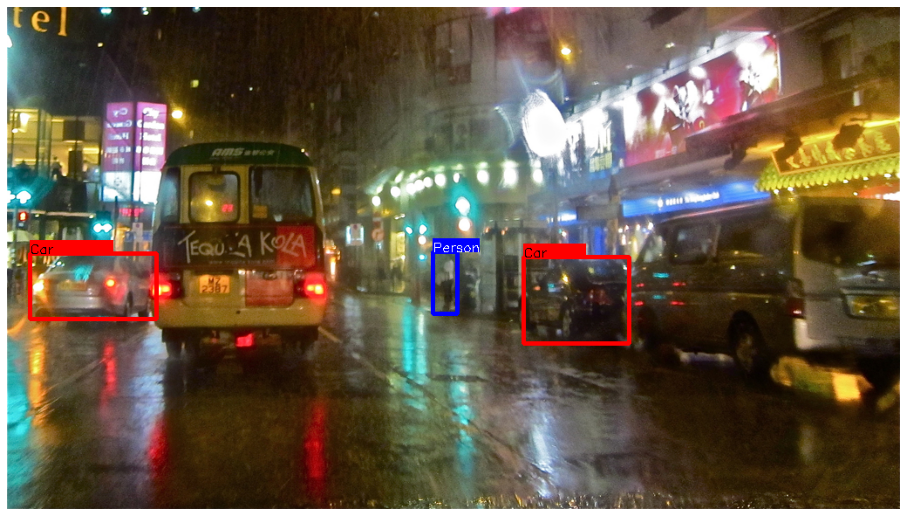

In [72]:
fig, ax = plt.subplots(figsize=(16,16))
draw_boxes(df, 'image_000000002.jpg', True)
plt.axis('off');

In [77]:
def apply_transformation_to_df(row):
    '''
    Calculate the bounding box coordinates for a dataframe
    '''

    bbox = row['bbox']
    top_left_x = bbox[0]
    top_left_y = bbox[1]
    width = bbox[2]
    height = bbox[3]
    
    bottom_right_x = width + top_left_x
    bottom_right_y = height + top_left_y
    
    row['x_min'] = top_left_x
    row['y_min'] = top_left_y
    row['x_max'] = bottom_right_x
    row['y_max'] = bottom_right_y
    row['annot_width'] = width
    row['annot_height'] = height

    if row['category_id'] == 1:
        row['category_text'] = 'Person'
    
    
    return row

In [78]:
df['x_min'] = 0
df['y_min'] = 0
df['x_max'] = 0
df['y_max'] = 0
df['annot_width'] = 0
df['annot_height'] = 0
df['category_text'] = 'Car'

In [79]:
df = df.apply(apply_transformation_to_df, axis=1)

In [80]:
df.head(2)

,file_name,width,height,id_x,license_x,file_path,category_id,image_id,segmentation,iscrowd,bbox,area,id_y,license_y,x_min,y_min,x_max,y_max,annot_width,annot_height,normalized_width,normalized_height,category_text
0,image_000000001.jpg,1024,768,0,1,./eagleview/data/raw/trainval/images/image_000...,1,0,[],0,"[846, 145, 146, 477]",0.088554,0,2,846,145,992,622,146,477,0.142578,0.621094,Person
1,image_000000001.jpg,1024,768,0,1,./eagleview/data/raw/trainval/images/image_000...,1,0,[],0,"[848, 216, 175, 551]",0.122611,1,2,848,216,1023,767,175,551,0.170898,0.717448,Person


In [81]:
df['normalized_width'] = df['annot_width'] / df['width']
df['normalized_height'] = df['annot_height'] / df['height']

df.head()

,file_name,width,height,id_x,license_x,file_path,category_id,image_id,segmentation,iscrowd,bbox,area,id_y,license_y,x_min,y_min,x_max,y_max,annot_width,annot_height,normalized_width,normalized_height,category_text
0,image_000000001.jpg,1024,768,0,1,./eagleview/data/raw/trainval/images/image_000...,1,0,[],0,"[846, 145, 146, 477]",0.088554,0,2,846,145,992,622,146,477,0.142578,0.621094,Person
1,image_000000001.jpg,1024,768,0,1,./eagleview/data/raw/trainval/images/image_000...,1,0,[],0,"[848, 216, 175, 551]",0.122611,1,2,848,216,1023,767,175,551,0.170898,0.717448,Person
2,image_000000001.jpg,1024,768,0,1,./eagleview/data/raw/trainval/images/image_000...,2,0,[],0,"[74, 159, 75, 81]",0.007725,2,2,74,159,149,240,75,81,0.073242,0.105469,Car
3,image_000000001.jpg,1024,768,0,1,./eagleview/data/raw/trainval/images/image_000...,2,0,[],0,"[153, 124, 658, 643]",0.537992,3,2,153,124,811,767,658,643,0.642578,0.837240,Car
4,image_000000002.jpg,1024,576,1,1,./eagleview/data/raw/trainval/images/image_000...,1,1,[],0,"[488, 281, 28, 71]",0.003370,4,2,488,281,516,352,28,71,0.027344,0.123264,Person


In [82]:
df.describe()

,width,height,id_x,license_x,category_id,image_id,iscrowd,area,id_y,license_y,x_min,y_min,x_max,y_max,annot_width,annot_height,normalized_width,normalized_height
count,16772.000000,16772.000000,16772.000000,16772.0,16772.00000,16772.000000,16772.0,16772.000000,16772.000000,16772.0,16772.000000,16772.000000,16772.000000,16772.000000,16772.000000,16772.000000,16772.000000,16772.000000
mean,999.082220,742.922371,1090.303363,1.0,1.35607,1090.303363,0.0,0.065363,8385.500000,2.0,422.889339,270.059027,569.586692,435.526353,146.697353,165.467326,0.148383,0.223521
std,102.926163,125.908542,642.705912,0.0,0.47885,642.705912,0.0,0.157283,4841.803693,0.0,300.326034,174.522806,301.863908,206.517234,205.134140,168.542397,0.204921,0.214782
min,575.000000,282.000000,0.000000,1.0,1.00000,0.000000,0.0,0.000000,0.000000,2.0,0.000000,0.000000,4.000000,3.000000,0.000000,3.000000,0.000000,0.003906
25%,1024.000000,683.000000,523.000000,1.0,1.00000,523.000000,0.0,0.002963,4192.750000,2.0,152.750000,133.000000,316.000000,282.000000,35.000000,56.000000,0.035156,0.076358
50%,1024.000000,696.000000,1082.000000,1.0,1.00000,1082.000000,0.0,0.010517,8385.500000,2.0,407.500000,261.000000,571.000000,422.000000,70.000000,108.000000,0.070105,0.147877
75%,1024.000000,768.000000,1630.000000,1.0,2.00000,1630.000000,0.0,0.038902,12578.250000,2.0,669.000000,376.000000,825.000000,570.000000,154.000000,208.000000,0.156250,0.286132
max,4496.000000,3000.000000,2238.000000,1.0,2.00000,2238.000000,0.0,0.998048,16771.000000,2.0,3883.000000,998.000000,4493.000000,2999.000000,3903.000000,2999.000000,0.999023,0.999667


# <a> 3. EDA </a>

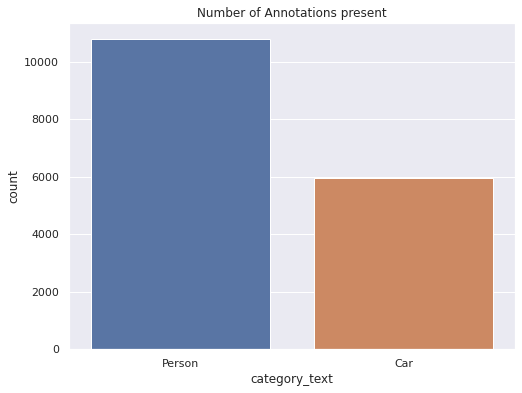

In [87]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x='category_text', data=df);

plt.title('Number of Annotations present');

In [88]:
df.category_text.value_counts(normalize=True) * 100

Person    64.393036
Car       35.606964
Name: category_text, dtype: float64

Almost 65% Annotations are of category Person, 35% are of category Car

In [93]:
len(df[df['category_id']==1]) / df['file_name'].nunique()

4.82358195623046

In [94]:
len(df[df['category_id']==2]) / df['file_name'].nunique()

2.66726217061188

On average there are close to 4.8 annotations for Person  and 2.6 annotations for car in a single image. 

# <a> 4. Clustering </a>

Objective: To find the correct size of anchor boxes for accurate object detection

### Data Preparation for clustering

In [95]:
cluster_data =[]
for w,h in list(zip(df['normalized_width'].values, df['normalized_height'].values)):
    cluster_data.append([w,h])

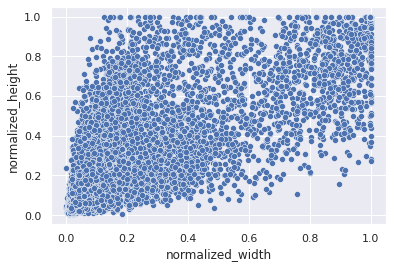

In [96]:
sns.scatterplot(x=df['normalized_width'], y=df['normalized_height'], data=df)

Not much can be concluded from this image!

Code and Idea taken from: https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html

In [97]:
def iou(box, clusters):
    '''
    :param box:      np.array of shape (2,) containing w and h
    :param clusters: np.array of shape (N cluster, 2) 
    '''
    x = np.minimum(clusters[:, 0], box[0]) 
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


In [98]:
def kmeans(boxes, k, dist=np.median,seed=1):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances     = np.empty((rows, k)) ## N row x N cluster
    last_clusters = np.zeros((rows,))

    np.random.seed(seed)

    # initialize the cluster centers to be k items
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        # Step 1: allocate each item to the closest cluster centers
        for icluster in range(k): # I made change to lars76's code here to make the code faster
            distances[:,icluster] = 1 - iou(clusters[icluster], boxes)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break
            
        # Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters,nearest_clusters,distances

### Finding Anchor boxes

In [99]:
kmax = 11
dist = np.mean
results = {}
for k in range(2,kmax):
    clusters, nearest_clusters, distances = kmeans(np.array(cluster_data),k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 2 clusters: mean IoU = 0.3715
 3 clusters: mean IoU = 0.4490
 4 clusters: mean IoU = 0.4910
 5 clusters: mean IoU = 0.5141
 6 clusters: mean IoU = 0.5509
 7 clusters: mean IoU = 0.5832
 8 clusters: mean IoU = 0.5991
 9 clusters: mean IoU = 0.6105
10 clusters: mean IoU = 0.6259


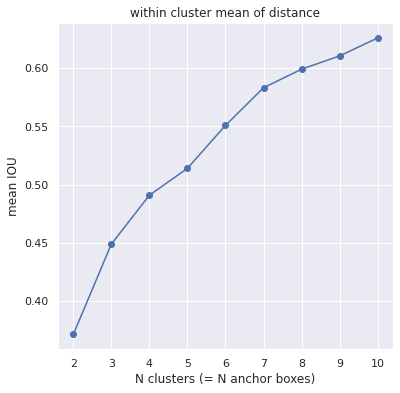

In [105]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(2,kmax),
         [1 - results[k]["WithinClusterMeanDist"] for k in range(2,kmax)],"o-")
plt.title("within cluster mean of distance")
plt.ylabel("mean IOU")
plt.xlabel("N clusters (= N anchor boxes)")
plt.show();

In [106]:
Nanchor_box = 4
results[Nanchor_box]["clusters"]

array([[0.11533819, 0.23374229],
       [0.3055497 , 0.4444695 ],
       [0.03892363, 0.08417956],
       [0.7783877 , 0.7382428 ]])

### Visualizing Anchor Boxes

In [107]:
final_results = results[Nanchor_box]["clusters"]

(0, 0)
(88, 239)


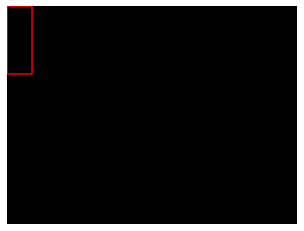

(0, 0)
(234, 455)


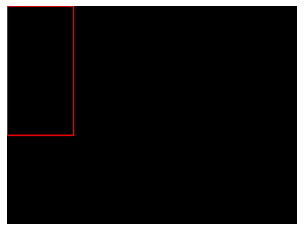

(0, 0)
(29, 86)


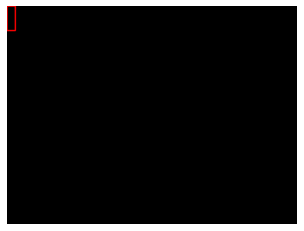

(0, 0)
(597, 755)


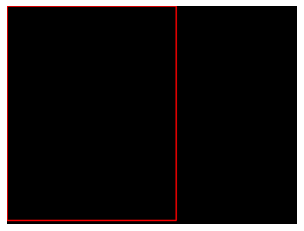

In [109]:
for i in results[Nanchor_box]["clusters"]:
    start_point=(0,0)
    end_point = (int(i[0]*768), int(i[1]*1024))
    print(start_point)
    print(end_point)
    blank_image = np.zeros((768,1024,3), np.uint8)
    cv2.rectangle(blank_image, start_point, end_point, (255,0,0), 4)
    plt.axis('off')
    plt.imshow(blank_image)
    plt.show()

### For person category

In [110]:

person_df = df[df['category_text'] == 'Person']
car_df = df[df['category_text'] == 'Car']

cluster_data =[]
for w,h in list(zip(person_df['normalized_width'].values, person_df['normalized_height'].values)):
    cluster_data.append([w,h])

In [111]:
kmax = 11
dist = np.mean
results = {}
for k in range(2,kmax):
    clusters, nearest_clusters, distances = kmeans(np.array(cluster_data),k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 2 clusters: mean IoU = 0.4326
 3 clusters: mean IoU = 0.5123
 4 clusters: mean IoU = 0.5568
 5 clusters: mean IoU = 0.5837
 6 clusters: mean IoU = 0.6006
 7 clusters: mean IoU = 0.6196
 8 clusters: mean IoU = 0.6414
 9 clusters: mean IoU = 0.6557
10 clusters: mean IoU = 0.6654


In [112]:
results[2]["clusters"]

array([[0.04209987, 0.12095761],
       [0.18359585, 0.44534393]])

(0, 0)
(32, 123)


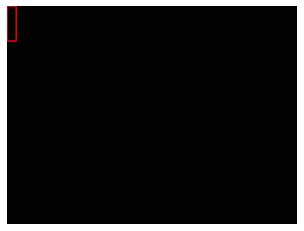

(0, 0)
(141, 456)


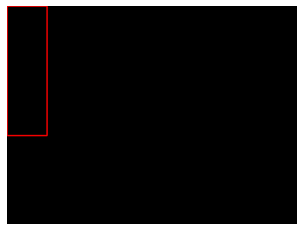

In [113]:
for i in results[2]["clusters"]:
    start_point=(0,0)
    end_point = (int(i[0]*768), int(i[1]*1024))
    print(start_point)
    print(end_point)
    blank_image = np.zeros((768,1024,3), np.uint8)
    cv2.rectangle(blank_image, start_point, end_point, (255,0,0), 4)
    plt.axis('off')
    plt.imshow(blank_image)
    plt.show()

## For Car Category

In [118]:
cluster_data =[]
for w,h in list(zip(car_df['normalized_width'].values, car_df['normalized_height'].values)):
    cluster_data.append([w,h])

In [119]:
kmax = 11
dist = np.mean
results = {}
for k in range(2,kmax):
    clusters, nearest_clusters, distances = kmeans(np.array(cluster_data),k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 2 clusters: mean IoU = 0.4035
 3 clusters: mean IoU = 0.4988
 4 clusters: mean IoU = 0.5515
 5 clusters: mean IoU = 0.5834
 6 clusters: mean IoU = 0.5990
 7 clusters: mean IoU = 0.6183
 8 clusters: mean IoU = 0.6341
 9 clusters: mean IoU = 0.6474
10 clusters: mean IoU = 0.6621


In [120]:
results[2]["clusters"]

array([[0.59580898, 0.53056467],
       [0.11423138, 0.10887087]])

(0, 0)
(457, 543)


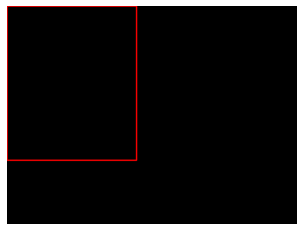

(0, 0)
(87, 111)


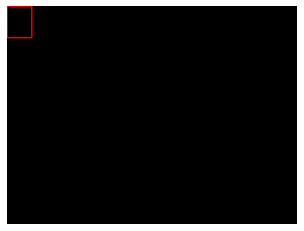

In [121]:
for i in results[2]["clusters"]:
    start_point=(0,0)
    end_point = (int(i[0]*768), int(i[1]*1024))
    print(start_point)
    print(end_point)
    blank_image = np.zeros((768,1024,3), np.uint8)
    cv2.rectangle(blank_image, start_point, end_point, (255,0,0), 4)
    plt.axis('off')
    plt.imshow(blank_image)
    plt.show()